# 3D Segmentation of Brain Tumor

This document is to propose a 2D methodology instead of treating it as a 3D input.


## Loading the Dataset
The dataset used is the BraTS 2020 Dataset.

The Dataset Contains the Following Scans per case:

T1: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.

T1c: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.

T2: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.

FLAIR: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

So for training T1ce, T2 and FLAIR will be used.

### Importing all dependencies

In [1]:
# Previewing the MRI Data
# TODO: Collect all imports later and add notes next to them
import numpy as np
import matplotlib.pyplot as plt
from os import path, listdir
from monai.data import Dataset, list_data_collate, DataLoader
from monai.transforms import (
    LoadImaged,
    Compose,
    MapTransform,
    Orientationd,
    EnsureTyped,
    ToMetaTensord,  # ? same as ensuretyped?
    EnsureChannelFirstd,
    NormalizeIntensityd,
    Spacingd,
    DivisiblePadd # ? For UNet needs to be divisible by?
)

from monai.networks.nets import SegResNet, UNet
from monai.losses import DiceLoss

from pytorch_lightning import seed_everything 
import torch
from utilities.split_data import train_val_test_dataset

from monai.utils.misc import first

c:\Users\ibrah\miniconda3\envs\fyp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed_everything(1607)

2023-01-09 20:45:16,321 - Global seed set to 1607


1607

In [3]:
# Prepare list of All training Cases
TRAINING_DATASET_PATH = r"./MICCAI_BraTS2020_TrainingData"
NAME_MAPPING = r"./MICCAI_BraTS2020_TrainingData/name_mapping.csv"

# Function returns names of cases to be used
train_cases, val_cases, test_cases = train_val_test_dataset(NAME_MAPPING)




          Ratio of Classes -> HGG/Total
          - Training 0.80	| 265 Cases.
          - Validation 0.79	| 67 Cases.
          - Testing 0.78	| 37 Cases.
          
          Total Cases: 369
          


In [4]:
# prepare mapping to convert into PyTorch Dataset
train_cases = [
    {
        "image": [
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t1ce.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t2.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_flair.nii.gz"),
        ],
        "seg": path.join(
            TRAINING_DATASET_PATH, case, f"{path.split(case)[-1]}_seg.nii.gz"
        ),
    }
    for case in train_cases
]

val_cases = [
    {
        "image": [
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t1ce.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t2.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_flair.nii.gz"),
        ],
        "seg": path.join(
            TRAINING_DATASET_PATH, case, f"{path.split(case)[-1]}_seg.nii.gz"
        ),
    }
    for case in val_cases
]

test_cases = [
    {
        "image": [
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t1ce.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t2.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_flair.nii.gz"),
        ],
        "seg": path.join(
            TRAINING_DATASET_PATH, case, f"{path.split(case)[-1]}_seg.nii.gz"
        ),
    }
    for case in test_cases
]


In [5]:
# One Hot Encoding for Tumor as 3 is skipped in the segmentation masks.
class ConvertLabelsIntoOneHotd(MapTransform):
    def __call__(self, data):
        data_dict = dict(data)
        for key in self.keys:
            one_hot_encode_array = [
                data_dict[key] == 1,  # Non Enhancing Tumor Core
                data_dict[key] == 2,  # Edema Core
                data_dict[key] == 4,  # Enhancing Tumor Core
            ]
            data_dict[key] = np.stack(one_hot_encode_array, axis=0).astype(np.float32)
        return data_dict


In [6]:
# Transform data such as from niftii into Tensors
transform_training_dataset = Compose(
    [
        LoadImaged(keys=["image", "seg"]),
        EnsureChannelFirstd(keys=["image"]),
        EnsureTyped(keys=["image", "seg"]),
        ConvertLabelsIntoOneHotd(keys="seg"),
        # Orientationd(keys=["image", "seg"], axcodes="RAS"),
        #! Causes misalignment on Mask
        Spacingd(
            keys=["image", "seg"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        DivisiblePadd(keys=["image", "seg"],k=16)
    ]
)

# TODO: Declare transforms for Testing and Validation Datasets


In [18]:
# Prepare the training Dataset with all transformations
# Optional: Can replace Dataset Class with Cache Dataset
dataset_training = Dataset(train_cases, transform_training_dataset)


In [19]:
print(dataset_training[0]["image"].shape)
print(dataset_training[0]["seg"].shape)

c:\Users\ibrah\miniconda3\envs\fyp\lib\site-packages\monai\transforms\spatial\array.py:571: UserWarning: `data_array` is not of type MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type MetaTensor, assuming affine to be identity.")


torch.Size([3, 240, 240, 160])
torch.Size([3, 240, 240, 160])


Dataset Produced in the following format
```
[list of dictionaries]
    - mri scan ["image"] -> [3,240,240,155] [Torch.Tensor]
    - seg mask ["seg] -> [3,240,240,155] [Torch.Tensor]
```

Where `[3,240,240,155]` refers to `[Channel,Dims..]`


## Visualising the Training Dataset

Text(0.5, 1.0, 'Enhancing')

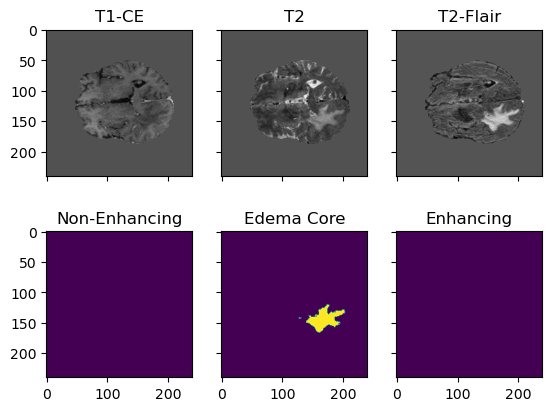

In [334]:
# Visualising the Training Dataset per case

#! Misalignment of Seg and Image Tensors when using Orientationd

case = 3  # Refers to a folder in the training dataset such as "./MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/"

slice = 68  # Refers to a slice in the 3D Tensor. For visualisation one of the 3 axis must be limited

to_plot_case = dataset_training[case]

fig, ax = plt.subplots(2, 3, sharey=True, sharex=True)

ax[0, 0].imshow(to_plot_case["image"][0][:, :, slice], cmap="gray")
ax[0, 0].set_title("T1-CE")

ax[0, 1].imshow(to_plot_case["image"][1][:, :, slice], cmap="gray")
ax[0, 1].set_title("T2")

ax[0, 2].imshow(to_plot_case["image"][2][:, :, slice], cmap="gray")
ax[0, 2].set_title("T2-Flair")


ax[1, 0].imshow(to_plot_case["seg"][0][:, :, slice])
ax[1, 0].set_title("Non-Enhancing")

ax[1, 1].imshow(to_plot_case["seg"][1][:, :, slice])
ax[1, 1].set_title("Edema Core")

ax[1, 2].imshow(to_plot_case["seg"][2][:, :, slice])
ax[1, 2].set_title("Enhancing")


# TODO
- Data Preprocessing
- ~~Choosing Data Loader -> Slice~~
- Choosing Encoder
- Choosing Decoder -> Append Encoder

add more as you go

In [ ]:
class Segmentation_Model(pl.LightningModule):
    def __init__(self) -> None:
        super().__init__()
        self.batch_size = 1
        self.num_workers = 2
        self.learning_rate = 1e-4
        # TODO: Define Models, Loss Functions and Metrics

        # https://docs.monai.io/en/stable/networks.html#segresnet
        self.model = SegResNet(
            blocks_down=[1, 2, 2, 4],
            blocks_up=[1, 1, 1],
            init_filters=8,
            in_channels=3,
            out_channels=3,
            dropout_prob=0.2,
            spatial_dims=2
        )

        self.loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)

        self.best_val_dice = 0
        self.best_val_epoch = 0

    # Data preparation
    def prepare_data(self):
        # Load the dataset once on model is instantiated
        self.train_ds = Dataset(train_cases, transform_training_dataset)
        # TODO: validation dataset transformations
        self.val_ds = Dataset(val_cases, transform_training_dataset)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_ds,
            shuffle=True,
            batch_size=self.batch_size,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_ds,
            shuffle=True,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    # Training and Validation
    def forward(self, x):
        # return self.Model -> Forward Pass
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        # image, seg = batch["image"], batch["seg"]
        # output = self.forward(image)
        # loss = self.loss_function(output, seg)
        # tensorboard_logs = {"train_loss": loss.item()}
        # return {"loss": loss, "log": tensorboard_logs}

        """
        In the traning loop pass slice from the each 3d view
        Ex:
        for i in range (batch["image"].size(4)):
            pass each slice to model

        follow models input standard -> [Batch, Channel, Dims]
        """

        batch_loss = []

        image, seg = batch["image"], batch["seg"]
        for slice_idx in range(image.size(4)): 
            output = self.forward(image[:,:,:,:,slice_idx])
            loss = self.loss_function(output,seg[:,:,:,:,slice_idx])

        pass

    def validation_step(self, batch, batch_idx):
        # image, seg = batch["image"], batch["seg"]
        # output = sliding_window_inference(
        #     inputs=image,
        #     roi_size=(240, 240, 160),
        #     sw_batch_size=1,
        #     predictor=self.forward,
        #     overlap=0.5,
        # )
        # loss = self.loss_function(output, seg)
        # output = [self.post_pred_image(i) for i in decollate_batch(output)]
        # self.dice_metric(y_pred=output, y=seg)
        # return {"val_loss": loss, "val_number": len(output)}
        pass

    def validation_epoch_end(self):
        # val_loss, num_items = 0, 0
        # for output in outputs:
        #     val_loss += output["val_loss"].sum().item()
        #     num_items += output["val_number"]

        # mean_val_dice = self.dice_metric.aggregate().item()
        # self.dice_metric.reset()
        # mean_val_loss = torch.tensor(val_loss / num_items)

        # tensorboard_logs = {
        #     'val_dice': mean_val_dice,
        #     'val_loss': mean_val_loss
        # }
        # if mean_val_dice > self.best_val_dice:
        #     self.best_val_dice = mean_val_dice
        #     self.best_val_epoch = self.current_epoch
        # print(
        #     f"current epoch: {self.current_epoch} "
        #     f"current mean dice: {mean_val_dice:.4f}"
        #     f"\nbest mean dice: {self.best_val_dice:.4f} "
        #     f"at epoch: {self.best_val_epoch}"
        # )
        # return {"log": tensorboard_logs}
        pass


In [9]:
#! Learning DataLoader
test_forward = SegResNet(
            blocks_down=[1, 2, 2, 4],
            blocks_up=[1, 1, 1],
            init_filters=8,
            in_channels=3,
            out_channels=3,
            dropout_prob=0.2,
            spatial_dims=2
        )

test_loss = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, softmax=True)

loss_values = []
for batch in temp_data_loader:
    image, seg = batch["image"], batch["seg"]
    for slice_idx in range(image.size(4)): 
        output = test_forward(image[:,:,:,:,slice_idx])
        loss = test_loss(output,seg[:,:,:,:,slice_idx])
        loss_values.append(loss)
        break
    
    break

c:\Users\ibrah\miniconda3\envs\fyp\lib\site-packages\monai\transforms\spatial\array.py:571: UserWarning: `data_array` is not of type MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type MetaTensor, assuming affine to be identity.")


# Training and Validation of Model

In [7]:
# Libraries for pure pytorch testing
import time
from tqdm import tqdm

In [10]:
train_data_loader = DataLoader(
    Dataset(train_cases[:100], transform_training_dataset),
    shuffle=True,
    batch_size=5,
)

#! transformation in validation dataset
val_data_loader = DataLoader(
    Dataset(val_cases[:5], transform_training_dataset),
    shuffle=True,
    batch_size=2,
)




In [11]:
#! Pure Pytorch Training Loop:
# Ref: https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/brats_segmentation_3d.ipynb
# Ref: https://github.com/Project-MONAI/tutorials/blob/main/2d_segmentation/torch/unet_training_dict.py


device = torch.device("cuda:0")

#! Update with proper values
max_epochs = 10
val_interval = 2

# model = SegResNet(
#     blocks_down=[1, 2, 2, 4],
#     blocks_up=[1, 1, 1],
#     init_filters=8,
#     in_channels=3,
#     out_channels=3,
#     dropout_prob=0.2,
#     spatial_dims=2,
# ).to(device)

model = UNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    channels=(15, 30, 60, 120, 240),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

initial_lr = 1e-3

optimizer = torch.optim.Adam(model.parameters(), initial_lr, weight_decay=1e-5)

scaler = torch.cuda.amp.GradScaler()

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=max_epochs, eta_min=1e-4
)

loss_function = DiceLoss(
    smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True
)

best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []


total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"Epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in tqdm(train_data_loader):

        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["seg"].to(device),
        )

        for slice_idx in range(inputs.size(4)):
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs[:, :, :, :, slice_idx])
                loss = loss_function(outputs, labels[:, :, :, :, slice_idx])

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()
            step += 1

    # lr_scheduler.step()
    epoch_loss /= step  # average epoch loss
    epoch_loss_values.append(epoch_loss)
    print(
        f"epoch {epoch + 1} average loss: {epoch_loss:.4f}\n"
    )

    """
    if (epoch + 1) % val_interval == 0:
        print(f"Validating Training at {(epoch + 1)} Epochs")
        model.eval()
        with torch.no_grad():
            for val_data in val_data_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["seg"].to(device),
                )

                for slice_idx in range(val_inputs.size(4)):

                    val_outputs = inference(val_inputs)
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    dice_metric(y_pred=val_outputs, y=val_labels)
                    dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            """


----------
Epoch 1/10


 30%|███       | 6/20 [01:51<04:20, 18.63s/it]


KeyboardInterrupt: 

In [41]:
model = UNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    channels=(15, 30, 60, 120, 240),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

testing_train_data_loader = first(train_data_loader)
print(testing_train_data_loader["image"].shape,testing_train_data_loader["seg"].shape)

c:\Users\ibrah\miniconda3\envs\fyp\lib\site-packages\monai\transforms\spatial\array.py:571: UserWarning: `data_array` is not of type MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type MetaTensor, assuming affine to be identity.")


torch.Size([5, 3, 240, 240, 160]) torch.Size([5, 3, 240, 240, 160])


In [ ]:
for i in tqdm(range(testing_train_data_loader["image"].size(4))):
    x = model(testing_train_data_loader["image"][:,:,:,:,i])
print(x.shape)